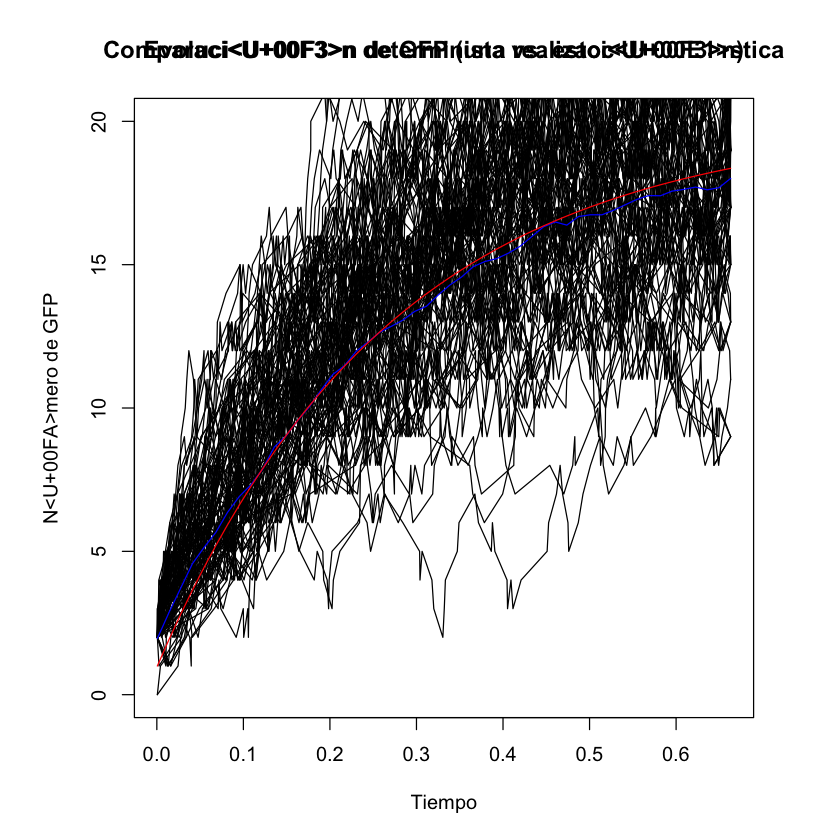

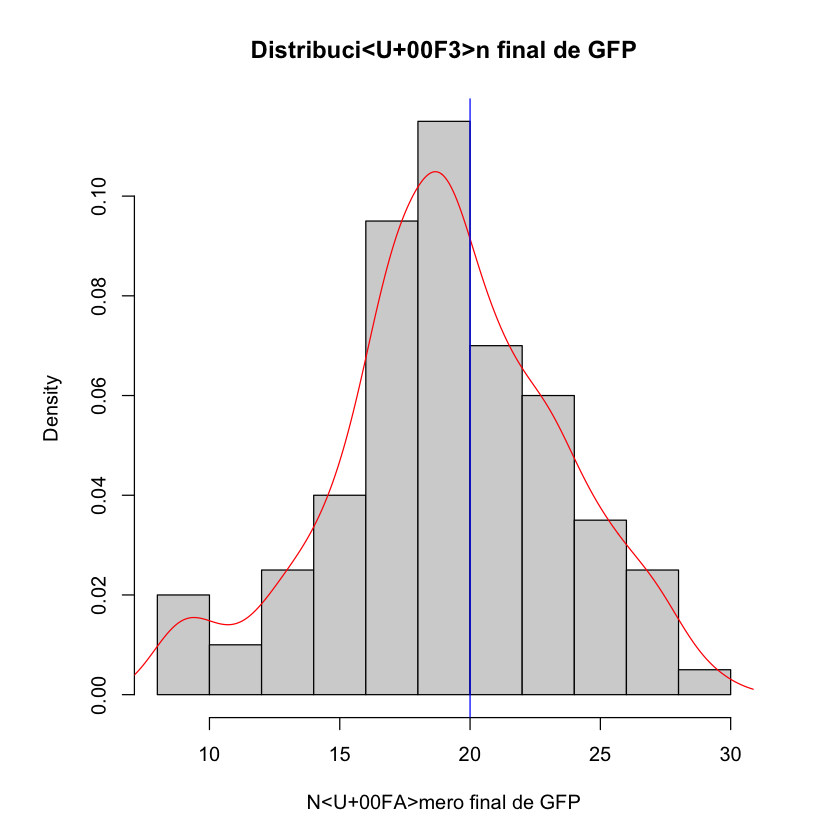

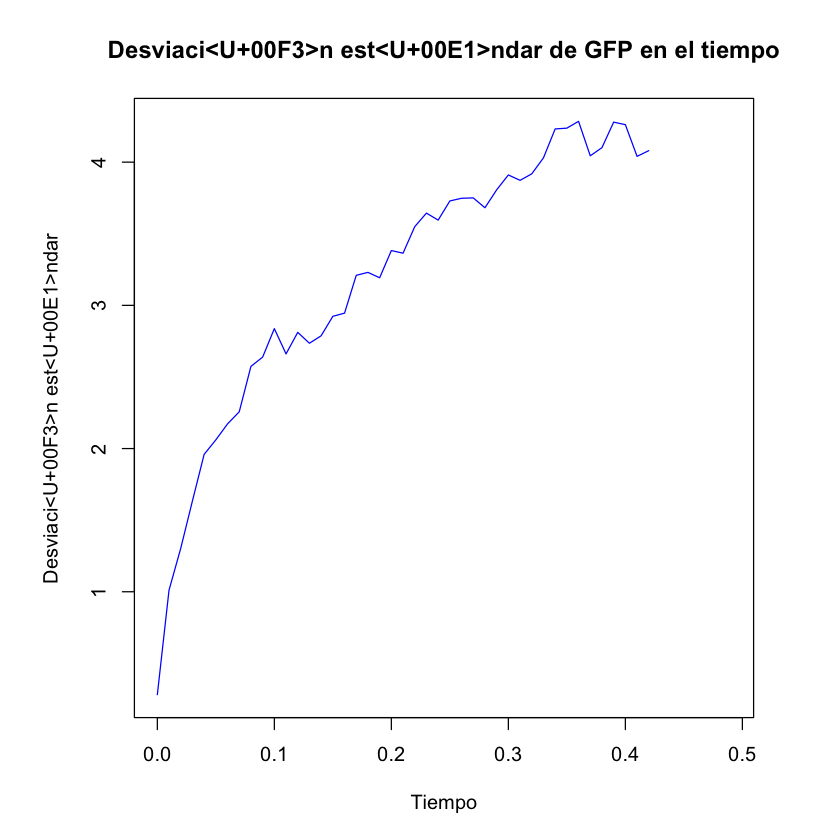

In [2]:
# ---------------------------------------------------------------------------------
# Simulación estocástica de la producción y degradación de GFP mediante el
# algoritmo de Gillespie
#
# Reacciones consideradas:
#   0 → GFP,  con tasa c1 (producción)
#   GFP → 0,  con tasa c2 (degradación)
# ---------------------------------------------------------------------------------

# -----------------------
# Configuración inicial
# -----------------------
IC = 1               # Condición inicial: número de moléculas de GFP al inicio
c1 = 100             # Constante de velocidad para la producción de GFP
c2 = 5               # Constante de velocidad para la degradación de GFP
n = 100              # Número de eventos (pasos de tiempo) en cada realización
iterations = 100     # Número de realizaciones (iteraciones) del proceso estocástico

# -----------------------
# Función de tasas de riesgo ("hazard functions")
# -----------------------
th = c(c1, c2)  # Vector de parámetros con las constantes de velocidad

# Función que calcula las tasas de cada reacción dado el estado actual "y"
h = function(y, th) {
  # Para la reacción 0 -> GFP: la tasa es c1 (constante)
  # Para la reacción GFP -> 0: la tasa es c2 * y (proporcional a la cantidad de GFP)
  return(c(th[1], th[2] * y))
}

# -----------------------
# Algoritmo de Gillespie para una única realización
# -----------------------
gillespieGFp <- function(IC, th, h, n) {
  v = length(th)      # Número de reacciones (en este caso, 2)
  tt = 0              # Tiempo inicial
  tvec = vector("numeric", n)  # Vector para almacenar los tiempos en que ocurren los eventos
  xvec = vector("numeric", n)  # Vector para almacenar el número de GFP en cada evento
  
  x = IC            # Estado inicial del sistema (número de moléculas de GFP)
  
  # Bucle que simula "n" eventos
  for (i in 1:n) {
    totH = sum(h(x, th))         # Suma total de las tasas (tasa global de ocurrencia de eventos)
    tt = tt + rexp(1, totH)        # Tiempo hasta el siguiente evento, extraído de una exponencial
    j = sample(v, 1, prob = h(x, th))  # Selección de la reacción que ocurre, ponderada por sus tasas
    
    # Actualización del estado según la reacción seleccionada
    if (j == 1) {
      x = x + 1   # Reacción de producción: se añade una molécula de GFP
    } else {      # j == 2
      x = x - 1   # Reacción de degradación: se elimina una molécula de GFP
    }
    
    # Registro de tiempo y estado tras el evento
    tvec[i] = tt
    xvec[i] = x
  }
  # Retorna una lista con los vectores de tiempo y número de GFP
  return(list(t = tvec, x = xvec))
}

# -----------------------
# Ejecución de una realización del algoritmo
# -----------------------
out = gillespieGFp(IC, th, h, n)
par(pty = "s")  # Configura el gráfico con proporciones cuadradas
plot(out$t, out$x, type = "l", ylim = range(c(out$t, out$x)),  
     main = "Evolución de GFP (una realización)", xlab = "Tiempo", ylab = "Número de GFP")

# ---------------------------------------------------------------------------------
# Discretización de la salida
#
# La función "discretize" transforma la salida del algoritmo (eventos en tiempos 
# irregulares) en una malla regular de tiempos (con paso dt), asignando a cada
# instante el valor del estado correspondiente.
# ---------------------------------------------------------------------------------
discretize <- function(out) {
  events = length(out$t)      # Número total de eventos en la realización
  start = 0                   # Tiempo inicial
  end = out$t[events]         # Tiempo final (último evento)
  dt = 0.01                   # Incremento de tiempo para la malla regular (elegir adecuadamente)
  len = (end - start) %/% dt  # Número de puntos en la malla
  x = vector("numeric", len) # Vector para almacenar el estado (GFP) en la malla
  t = vector("numeric", len) # Vector para almacenar los tiempos discretizados
  
  target = 0  # Tiempo objetivo inicial
  j = 1       # Índice para la malla
  # Recorre todos los eventos y rellena la malla con el valor del estado correspondiente
  for (i in 1:events) {
    while (out$t[i] >= target) {
      x[j] = out$x[i]   # Asigna el valor actual de GFP al instante correspondiente
      t[j] = target     # Registra el instante de tiempo
      j = j + 1
      target = target + dt  # Incrementa el tiempo objetivo
      # Si se supera la longitud de la malla, salir del bucle
      if(j > len) break
    }
    if(j > len) break
  }
  return(list(tdisc = t, xdisc = x))
}

# ---------------------------------------------------------------------------------
# Realización de múltiples simulaciones para obtener distribuciones
# ---------------------------------------------------------------------------------

# Vector para almacenar el valor final (última molécula de GFP) de cada realización
xENDvec = vector("numeric", iterations)
numPoints = 50  # Número de puntos a tomar de la malla regular para análisis
regularOutMatrix = matrix(0, nrow = numPoints, ncol = iterations)

# Bucle que realiza "iterations" simulaciones
for (ii in 1:iterations) {
  # Se ejecuta una realización del algoritmo
  out2 = gillespieGFp(IC, th, h, n)
  
  # Discretiza la salida en una malla regular
  discOut = discretize(out2)
  # Guarda los primeros "numPoints" de la trayectoria discretizada en la matriz
  regularOutMatrix[, ii] = discOut$xdisc[1:numPoints]
  
  # Graficar (sin ejes ni etiquetas) la trayectoria de cada realización para sobreponerlas
  par(new = TRUE)
  plot(out2$t, out2$x, type = "l", ylim = range(c(out$t, out$x)), 
       axes = FALSE, xlab = "", ylab = "")
  
  # Almacena el valor final de GFP de esta realización
  xENDvec[ii] = out2$x[n]
}

# Sobreponer la media de las realizaciones en la malla regular
par(new = TRUE)
plot(discOut$tdisc[1:numPoints], rowMeans(regularOutMatrix, 1), type = "l", 
     col = "blue", ylim = range(c(out$t, out$x)), axes = FALSE, xlab = "", ylab = "")

# ---------------------------------------------------------------------------------
# Comparación con la solución determinista
#
# Se utiliza la librería "deSolve" para resolver la ecuación diferencial ordinaria
# que describe la evolución de GFP en ausencia de fluctuaciones estocásticas:
#
#   dGFP/dt = c1 - c2 * GFP
#
# Se grafica la solución determinista para comparar con la media de las realizaciones
# ---------------------------------------------------------------------------------
library(deSolve)

detGFP <- function(t, y, parms) {
  list(c1 - c2 * y)
}

# Se toma el vector de tiempos discretizados de la última realización
times <- discOut$tdisc[1:numPoints]
# Resolver la EDO determinista
outD <- ode(y = IC, times = times, func = detGFP, parms = NULL)
par(new = TRUE)
plot(outD, type = "l", col = "red", ylim = range(c(out$t, out$x)), 
     axes = FALSE, xlab = "", ylab = "", main = "Comparación determinista vs. estocástica")

# ---------------------------------------------------------------------------------
# Histograma de valores finales de GFP de todas las realizaciones
# ---------------------------------------------------------------------------------
par(new = FALSE)
hist(xENDvec, prob = TRUE, main = "Distribución final de GFP", 
     xlab = "Número final de GFP", col = "lightgray")
par(new = TRUE)
lines(density(xENDvec), col = "red")  # Densidad estimada
abline(v = c1 / c2, col = "blue")       # Valor de equilibrio determinista (c1/c2)

# ---------------------------------------------------------------------------------
# Gráfico de la desviación estándar en la malla regular a lo largo del tiempo
# ---------------------------------------------------------------------------------
par(new = FALSE)
plot(discOut$tdisc[1:numPoints], apply(regularOutMatrix[1:numPoints, ], 1, sd), 
     type = "l", col = "blue", xlab = "Tiempo", ylab = "Desviación estándar", 
     main = "Desviación estándar de GFP en el tiempo")
